In [214]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from get_images import get_images

# Cargar MNIST

In [215]:
MNIST_PATH = './Dataset/'

In [216]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [217]:
x_train_num.shape, y_train_num.shape, x_test_num.shape, y_test_num.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [218]:
type(x_train_num)

numpy.ndarray

# Split into differents sets the dataset 

In [219]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)


## Validate the shape of the data sets

In [220]:
print(x_train.shape) #(50000, 784)
print(y_train.shape) #(50000, 1)

print(x_val.shape) # (10000,784)
print(y_val.shape) # (10000, 1)

print(x_test.shape) # (10000, 784)
print(y_test.shape) # (10000, 1)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


In [221]:
x_train.max()

1.0

## Graph some images

In [222]:
def plot_number(image: np.ndarray):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray')) #Squeeze elimina la primera dimension de la imagen para tener una iamgen de tamano (w,h)
    plt.axis('off') #No axis for the plot

La imagen mostrada corresponde a un: [1]


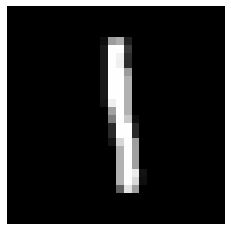

In [223]:
rand_index = np.random.randint(len(y_test_num))
print(f'La imagen mostrada corresponde a un: [{y_test_num[rand_index]}]')
plot_number(x_test_num[rand_index])

# Implement model

$$ z^1 = W^1X+b^1$$
$$ a^1 = ReLU(z^1) $$
$$ z^2 = W^2a^1 + b^2$$
$$ \hat y = \frac{e^{z^{2}}}{\sum_{j}e^{z_j}}$$

## Create mini batches

In [224]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x: 50000, 784
    y: 50000, 1
    '''
    assert x.shape[0] == y.shape[0], 'error with x and y sets'
    total_data = x.shape[0]

    if(shuffle):
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))


## Initialize parameters

In [225]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> input elements: 784
    neurons -> list [200, 10] numbers of neurons per layer
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001 #(l^i, l^{i-1})
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [226]:
parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(10, 1)


In [227]:
def relu(x):
    return np.maximum(0, x)

In [228]:
def scores(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [229]:
scores,z1, a1 = scores(x_train[:64].T, parameters, relu) 

In [230]:
x_train[:64].T.shape

(784, 64)

In [231]:
scores.shape

(10, 64)

In [232]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

In [233]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

In [234]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] = 0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads
    

In [235]:
y_hat, cost = x_entropy(scores, y_train[:64])

In [236]:
y_hat.shape

(10, 64)

In [237]:
print(cost)

2.302585300701576


In [238]:
grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, scores, parameters)

In [239]:

def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [240]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters

In [241]:
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

TypeError: 'numpy.ndarray' object is not callable